## Assignment- 18_Forecasting(Cocacola)

In [1]:
##Importing the necessary libraries for the model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing the csv file and having a glance at the data
cocacola_data=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
cocacola_data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


### Making necessary EDA for the model

In [3]:
#Looking into the rows and columns of the data
cocacola_data.shape

(42, 2)

In [4]:
#Looking the datatypes and null values if present any in the data
cocacola_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [5]:
#Checking the statistical report of the data
cocacola_data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


<AxesSubplot:>

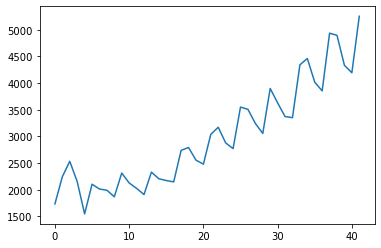

In [6]:
#To identify the past trend and perform analytics on the data
cocacola_data.Sales.plot()

In [7]:
param=pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

In [8]:
#Seperating and Aggregating the Quarters and years present in the 'Quarter' column of the original data, in order to do one hot encoding.
cocacola_data['Quarters']=0
cocacola_data['Year']=0
for i in range(42):
    p=cocacola_data['Quarter'][i]
    cocacola_data['Quarters'][i]=p[0:2]
    cocacola_data['Year'][i]=p[3:5]    
cocacola_data.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [9]:
#creating the dummy variables
quater_dumies=pd.DataFrame(pd.get_dummies(cocacola_data['Quarters']))
quater_dumies.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [10]:
#Concatinating the new dummy variables that are created for the Quarter column with the original dataset
cocacola_data=pd.concat([cocacola_data,quater_dumies],axis=1)
cocacola_data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [11]:
#Creating a squared time and time column for the dataset, which will be used in the Quadratic model
cocacola_data['time']=range(1,43)
cocacola_data['time_sqr']=cocacola_data['time']*cocacola_data['time']

In [12]:
#Creating a log transformation on the target variable
cocacola_data['log_sales']=np.log(cocacola_data['Sales'])
cocacola_data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,time,time_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


<AxesSubplot:xlabel='Year', ylabel='Sales'>

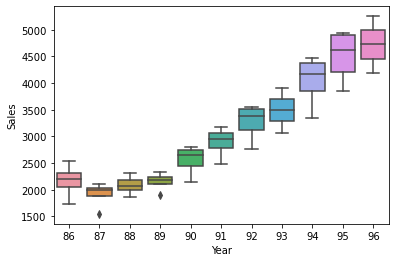

In [13]:
#A box plot to visualize the sales of coca cola throughout the years with 4 components - Trend, Cyclic,Seasonality and Irregularity component
sns.boxplot(x='Year',y='Sales',data=cocacola_data)

<AxesSubplot:xlabel='Year', ylabel='Sales'>

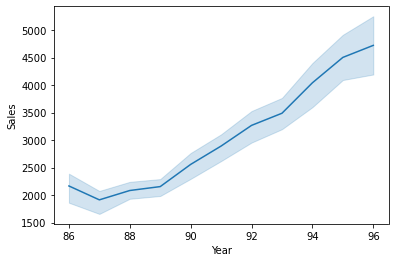

In [14]:
#Line plot to understand the past sales growth and to forecast the predictions
sns.lineplot(x='Year',y='Sales',data=cocacola_data)

In [15]:
#Splitting the train and test data
train=cocacola_data.head(30)
test=cocacola_data.tail(15)

## Building the Model driven methods for forecasting

### Performing Linear model

In [16]:
linear_model = smf.ols('Sales~time',data=cocacola_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['time'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

431.7994415690708

### Performing an exponential model

In [17]:
Exp = smf.ols('log_sales~time',data=cocacola_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['time'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

399.10160837656923

### Performing a quadratic model

In [18]:
Quad = smf.ols('Sales~time+time_sqr',data=cocacola_data).fit()
pred_Quad = pd.Series(Quad.predict(test[["time","time_sqr"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

378.64456526956195

### Performing an additive seasonality model

In [19]:
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=cocacola_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1185.65450291955

### Performing an additive seasonality quadratic model

In [20]:
add_sea_Quad = smf.ols('Sales~time+time_sqr+Q1+Q2+Q3+Q4',data=cocacola_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['time','time_sqr','Q1','Q2','Q3','Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

157.85145830299487

### Performing a multiplicative seasonality model

In [21]:
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4',data = cocacola_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1311.2517033919933

### Developing a multiplicative additive seasonality model